## Importing libraries

In [1]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Loading data

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [4]:
print(metadata)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    file_format=tfrecord,
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=string),
        'pt': Text(shape=(), dtype=string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    ci

In [5]:
print(type(train_examples))
print(type(val_examples))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [6]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Preprocessing the data

In [7]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [8]:
tokenizers = tf.saved_model.load(model_name)

In [9]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_TOKENS=128

In [11]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [12]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [13]:
print(type(train_batches))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [14]:
print(len(train_batches))

810


In [15]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 106)
(64, 105)
(64, 105)


In [16]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   87 1631   15   15   15    0    0    0    0], shape=(10,), dtype=int64)
tf.Tensor([  87 1631   15   15   15    3    0    0    0    0], shape=(10,), dtype=int64)


## Defining the components

### 1. Positional Embedding Layer

In [17]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

positional_encoding(4, 2).shape

TensorShape([4, 2])

In [18]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]  # No of words
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [19]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

# pt and en are single sentences
pt_emb = embed_pt(pt)
en_emb = embed_en(en)
print(pt_emb.shape)
print(en_emb.shape)

(64, 106, 512)
(64, 105, 512)


In [20]:
mask_dec = tf.cast(en_emb._keras_mask, tf.float32) # for decoder
mask_enc = tf.cast(pt_emb._keras_mask, tf.float32) # for encoder
print(mask_dec.shape)
print(mask_enc.shape)

(64, 105)
(64, 106)


### 2. Attention Layers

In [48]:
class MultiheadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model  # e.g., 300
        self.num_heads = num_heads  # e.g., 10

        self.depth = d_model // self.num_heads  # e.g., 30

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.proj = tf.keras.Sequential([
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout)
        ])

    def split_heads(self, x, batch_size):
        # Shape of x: (batch_size, n, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch, heads, n, depth)

    def scaled_dot_product_attention(self, q, k, v, mask, causal_mask, cross_attention=False):
        # Shape of q, k, v: (batch, num_heads, n, depth)
        # For cross attention: q is (batch, num_heads, n, 1, depth) and k, v are (batch, num_heads, 1, n_context, depth)
        # For cross attention up: q is (batch, num_heads, n, depth) and k, v are (batch, num_heads, n_context, depth)
        n = q.shape[2]
        # n_context = k.shape[3]
        n_context = k.shape[2]
        batch_size = q.shape[0]
        # print(f'n is: {n}')
        # print(f'n context is: {n_context}')
        # print(f'batch size is: {batch_size}')
        # print(f'shape of q is: {q.shape} and of k is: {k.shape} and of v is: {v.shape}')

        matmul_qk = tf.matmul(q, k, transpose_b=True)  # Shape: (batch, num_heads, n, d) * (batch, num_heads, d, n) --> (batch, num_heads, n, n)
        # For cross attention: (batch, num_heads, n, 1, depth) * (batch, num_heads, 1, n_context, depth) --> (batch, num_heads, n, 1, n_context)
        # For cross attention up: (batch, num_heads, n, depth) * (batch, num_heads, n_context, depth) --> (batch, num_heads, n, n_context)
        # print(f'shape of qk is: {matmul_qk.shape}')

        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)  # Shape: (batch, num_heads, n, n)
        # For cross attention, shape would be: (batch, num_heads, n, 1, n_context)
        # For cross attention up, shape would be: (batch, num_heads, n, n_context)
        # print(f'shape of mask is: {mask.shape}')
        # print(f"Cross attention is: {cross_attention}")
        # print(f'causal_mask is: {causal_mask}')

        if mask is not None:
            # Originally mask is of shape (batch, n), but here:
            if cross_attention:
              # Mask should be of shape: (batch, 1, n, 1, 1)
              # Mask should be of shape up: (batch, 1, n, 1)
              # reshaped_mask = tf.reshape(mask, (batch_size, 1, n, 1, 1))
              reshaped_mask = tf.reshape(mask, (batch_size, 1, n, 1))
              # print(f"Reshaping mask according to cross att, shape: {reshaped_mask.shape}")
            else:
              # Mask should be of shape: (batch, 1, 1, n)
              reshaped_mask = tf.reshape(mask, (batch_size, 1, 1, n))
              # print(f"Reshaping mask according to normal att, shape: {reshaped_mask.shape}")

            scaled_attention_logits += reshaped_mask*-1e9  # Apply mask
            # print(f'shape of attention logits after masking: {scaled_attention_logits.shape}')

        # Shape of logits before causal mask: (batch, num_heads, n, n)
        if causal_mask:
            mask = tf.linalg.band_part(tf.ones((1, 1, n, n), dtype=tf.int32), num_lower=-1, num_upper=0)  # Shape: (1, 1, n, n)
            mask = tf.where(mask==0, 1e-9, 1)
            # print(f'causal mask shape is: {mask.shape}')
            scaled_attention_logits = scaled_attention_logits * mask
            # print(f'after applying causal mask, shape of attention logits: {scaled_attention_logits.shape}')

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # Shape: (batch, num_heads, n, n)
        # print(f'attention weights shape is: {attention_weights.shape}')
        # If cross_attention: (batch, num_heads, n, 1, n_context)
        # If cross_attention up: (batch, num_heads, n, n_context)

        output = tf.matmul(attention_weights, v)  # Shape: (batch, num_heads, n, depth)
        # For cross attention: (batch, num_heads, n, 1, n_context) *  (batch, num_heads, 1, n_context, depth) --> (batch, num_heads, n, 1, depth)
        # For cross attention up: (batch, num_heads, n, n_context) *  (batch, num_heads, n_context, depth) --> (batch, num_heads, n, depth)

        # if cross_attention:
        #   # print(f'Shape of output at the end of cross attention is: {output.shape}')
        #   output = tf.squeeze(output, axis=3)

        # print(f'shape of output is: {output.shape}')
        return output, attention_weights


    def call(self, query, key, value, mask, causal_mask, cross_attention=False):
        # Shape of x: (batch_size, n, d_model)
        batch_size = tf.shape(query)[0]

        q = self.wq(query)  # (batch_size, n, d_model)
        k = self.wk(key)  # (batch_size, n_context, d_model)
        v = self.wv(value)  # (batch_size, n_context, d_model)

        q = self.split_heads(q, batch_size) # (batch, heads, n, depth)
        k = self.split_heads(k, batch_size) # (batch, heads, n_context, depth)
        v = self.split_heads(v, batch_size) # (batch, heads, n_context, depth)

        # if cross_attention:
        #   q = tf.expand_dims(q, axis=3)  # (batch, heads, n, 1, depth)
        #   k = tf.expand_dims(k, axis=2)  # (batch, heads, 1, n_context, depth)
        #   v = tf.expand_dims(v, axis=2)  # (batch, heads, 1, n_context, depth)


        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask, causal_mask, cross_attention) # (batch, num_heads, n, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        concat_attention = self.proj(concat_attention)

        return concat_attention, attention_weights

In [46]:
# # Cross attention test
# mha = MultiheadAttention(num_heads=16, d_model=64)

# b = 32
# d = 64
# n = 10
# n_context = 20

# q = tf.ones((b, n, d))
# k = tf.ones((b, n_context, d))
# v = tf.ones((b, n_context, d))
# mask = tf.ones((b, n), dtype=tf.float32)

# print(q.shape)
# print(k.shape)
# print(v.shape)
# print(mask.shape)
# print(f'context: {n_context} and n: {n}')

# mha(query=q, key=k, value=v, mask=mask, causal_mask=False, cross_attention=True)[0].shape

In [47]:
# # Causal attention test
# mha = MultiheadAttention(num_heads=2, d_model=200)
# inp = tf.random.uniform((3, 5, 10))
# mask = tf.zeros((3, 5))
# mask = tf.reshape(mask, (3, 1, 1, 5))
# output = mha(inp, inp, inp, mask, True)[0]
# print(output.shape)

In [24]:
# All its child layers need num_heads and key_dim(or dmodel) for initialization
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiheadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [25]:
class CrossAttention(BaseAttention):
  def call(self, x, context, mask):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        mask=mask,
        causal_mask=False,
        cross_attention=True)

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
sample_ca = CrossAttention(num_heads=2, d_model=512)

print('context:', pt_emb.shape)
print('input:', en_emb.shape)
print('mask:', mask_dec.shape)

sample_ca(en_emb, pt_emb, mask_dec).shape

context: (64, 106, 512)
input: (64, 105, 512)
mask: (64, 105)


TensorShape([64, 105, 512])

In [27]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x, mask):
    attn_output, attention_score = self.mha(
        query=x,
        value=x,
        key=x,
        mask=mask,
        causal_mask=False)

    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [28]:
sample_gsa = GlobalSelfAttention(num_heads=2, d_model=512)

print(pt_emb.shape)
print(mask_enc.shape)
print(sample_gsa(pt_emb, mask_enc).shape)

(64, 106, 512)
(64, 106)
(64, 106, 512)


In [29]:
class CausalSelfAttention(BaseAttention):
  def call(self, x, mask):
    attn_output, attention_scores = self.mha(
        query=x,
        value=x,
        key=x,
        mask=mask,
        causal_mask=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [30]:
sample_csa = CausalSelfAttention(num_heads=2, d_model=512)

print(en_emb.shape)
print(sample_csa(en_emb, mask_dec).shape)

(64, 105, 512)
(64, 105, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:


In [31]:
# out1 = sample_csa(embed_en(en[:, :3]))
# out2 = sample_csa(embed_en(en))[:, :3]

# tf.reduce_max(abs(out1 - out2)).numpy()

### 3. Feed Forward Layer

In [32]:
# This layer needs dmodel and dff for initialization
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(d_model*10, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [33]:
sample_ffn = FeedForward(600)

inp = tf.random.uniform((10, 600))  # n, d
print(inp.shape)
print(sample_ffn(inp).shape)

(10, 600)
(10, 600)


### 4. Encoder

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        d_model=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model)

  def call(self, x, mask):
    x = self.self_attention(x, mask)
    x = self.ffn(x)
    return x

In [35]:
sample_enc_layer = EncoderLayer(d_model=512, num_heads=2, dropout_rate=0.1)

print(pt_emb.shape)
print(sample_enc_layer(pt_emb, mask_enc).shape)

(64, 106, 512)
(64, 106, 512)


In [36]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    mask = tf.cast(x._keras_mask, tf.float32)

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, mask)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [37]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 106)
(64, 106, 512)


### 5. Decoder

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        d_model=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        d_model=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model)

  def call(self, x, context, mask):
    x = self.causal_self_attention(x=x, mask=mask)
    x = self.cross_attention(x=x, context=context, mask=mask)

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [39]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb, mask=mask_dec
)

print(sample_decoder_layer_output.shape)

(64, 105, 512)


In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    mask = tf.cast(x._keras_mask, tf.float32)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context, mask)

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [41]:
# Instantiate the decoder
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 105)
(64, 106, 512)
(64, 105, 512)


### 6. Transformer

In [42]:
@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Hyperparameters

In [43]:
num_layers = 4
d_model = 128
num_heads = 8
dropout_rate = 0.1

In [44]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [45]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 105)
(64, 106)
(64, 105, 7010)


In [ ]:
# attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
# print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2576512   
                                                                 
 decoder_1 (Decoder)         multiple                  2745088   
                                                                 
 dense_158 (Dense)           multiple                  904290    
                                                                 
Total params: 6225890 (23.75 MB)
Trainable params: 6225890 (23.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training Preparation



In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

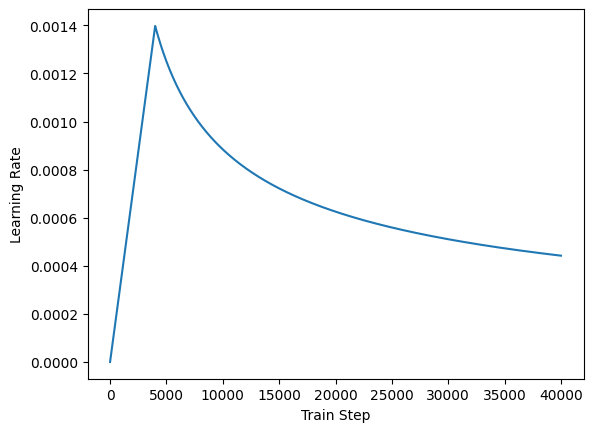

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Set up loss metrics


In [ ]:
def masked_loss(label, pred):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)
  print()

  mask = label!=0
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  mask = label!=0
  match = label==pred
  match  = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Train the model

In [ ]:
# Define the custom training loop
file_path = "results.txt"
n_epochs = 1
train_size = len(train_batches)
val_size = len(val_batches)
cur_epoch = 0

def custom_training_loop(model, train_batches, val_batches, epochs, optimizer, loss_fn):
    global cur_epoch
    for epoch in range(epochs):
        total_loss = 0
        total_accuracy = 0

        cur_train = 0
        cur_val = 0

        # Training
        for batch, (input_data, target_data) in enumerate(train_batches.take(1)):
            with tf.GradientTape() as tape:
                predictions = model(input_data, training=True)
                loss = loss_fn(target_data, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)

            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            accuracy = masked_accuracy(target_data, predictions)

            total_loss += loss
            total_accuracy += accuracy

            print(f"Epoch: {cur_epoch}  Train Batch: {cur_train}/{train_size}")
            cur_train += 1

        average_loss = total_loss / (batch + 1)
        average_accuracy = total_accuracy / (batch + 1)

        # Open the file in append mode
        with open(file_path, "a") as file:
            string_to_append = f"Epoch {epoch + 1}/{epochs} - Loss: {average_loss:.4f} - Accuracy: {average_accuracy:.4f}"
            file.write(string_to_append)
            file.write("\n")

        # Validation
        total_val_loss = 0
        total_val_accuracy = 0
        for batch, (input_data, target_data) in enumerate(val_batches.take(1)):
            predictions = model(input_data, training=False)
            loss = loss_fn(target_data, predictions)
            accuracy = masked_accuracy(target_data, predictions)

            total_val_loss += loss
            total_val_accuracy += accuracy

            print(f"Epoch: {cur_epoch}  Val Batch: {cur_val}/{val_size}")
            cur_val += 1

        average_val_loss = total_val_loss / (batch + 1)
        average_val_accuracy = total_val_accuracy / (batch + 1)

        with open(file_path, "a") as file:
            string_to_append = f"Validation Loss: {average_val_loss:.4f} - Validation Accuracy: {average_val_accuracy:.4f}"
            file.write(string_to_append)
            file.write("\n\n")

        cur_epoch += 1

# Call the custom training loop
custom_training_loop(transformer, train_batches, val_batches, epochs=n_epochs, optimizer=optimizer, loss_fn=masked_loss)



Epoch: 0  Train Batch: 0/810

Epoch: 0  Val Batch: 0/19


In [ ]:
# transformer.compile(
#     loss=masked_loss,
#     optimizer=optimizer,
#     metrics=[masked_accuracy])

In [ ]:
# transformer.fit(train_batches,
#                 epochs=20,
#                 validation_data=val_batches)

In [ ]:
# transformer.save('model.keras')

In [ ]:
# # Load the saved model
# loaded_transformer = tf.keras.models.load_model('model.keras')

## Translator

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence  # (1, 11)

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]  # shape=(2,)
    start = start_end[0][tf.newaxis]  # shape=(1,)
    end = start_end[1][tf.newaxis]  # shape=(1,)

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())  # (1, X)
      predictions = self.transformer([encoder_input, output], training=False)
      # print(f"Shape of prediction is: {predictions.shape}")
      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])  # Writing a tensor of shape 1

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

# Testing

In [ ]:
cont = tf.ones((1, 11))
enc = tf.ones((1, 2))

In [ ]:
context = transformer.encoder(cont)
print(context.shape)

(1, 11, 128)


In [ ]:
x = transformer.decoder(enc, context)